In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp
import time
from bayes_opt import BayesianOptimization
from scipy.optimize import root_scalar
import pymongo
import seaborn as sns
from scipy import special
import White_class
from scipy import integrate

In [3]:
#Main variables

main_detune = 17
sideband_detune = 120
white_detune = 10
laser_on = 200000
laser_off = 400015
MOT_power = 50
v0_start=1
v0_step=1
v0_end=25
t0_start=0
t0_step=1
t0_end=3500000


Gamma = 22 # Hz to kHz, Decay rate
wavelength = 359.3e-9 # m to mm
k = 1/wavelength*2*np.pi #x_0
x0 = 1/k
t0 = 1/Gamma*1/(2*np.pi*1e6)
v0 = x0/t0
m0 = cts.hbar*t0/x0**2
a0 = x0/t0**2
F0 = cts.hbar/(x0*t0)
mass = 43*cts.value('atomic mass constant')/m0 # m_0
mag_field_grad = 1252.8168984164048*x0
waist = 0.012/x0
v_max = 8.
z_max = 384.855e-3/x0
z_start = 384.855e-3/x0
omega = 2*np.pi*(cts.c/wavelength) #Transition frequency
Isat = np.pi*cts.h*cts.c*Gamma*2*np.pi*1e6/3*1/(wavelength)**3
t_eval = np.arange(t0_start,t0_end,t0_step)

# The detunings used in the PRAs:
intensities = 2.*MOT_power*1e-3/(np.pi*0.012**2)/Isat

#Define the hamiltonian
H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(N=1,I=0.5,B=15496.8125/Gamma,
gamma = 50.697/Gamma,b=154.7/Gamma, c=178.5/Gamma,gI=5.585,gS=2.0023193043622,
    muB = cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,
    muN=cts.m_e/cts.m_p*cts.value('Bohr magneton in Hz/T')*1e-4*1e-6/Gamma,return_basis=True
    )

# b : SI coupling(isotropic), c : Iz Sz coupling(anisotropic), cc : I N coupling, gamma : S N coupling

E_X = np.unique(np.diag(H0_X))

H0_A, Bq_A, Abasis = pylcp.hamiltonians.XFmolecules.Astate(J=0.5,I=0.5,
    P=+1,B=15788.2/Gamma,D=0.,H=0.,a=0./Gamma,b=-0.4/Gamma,c=0.,q=0., p=15./Gamma,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,
    muN=cts.m_e/cts.m_p*cts.value('Bohr magneton in Hz/T')*1e-4*1e-6/Gamma,return_basis=True
    )

# gJ : Lande g-factor, p : parity(e parity)

E_A = np.unique(np.diag(H0_A))

dijq = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    Xbasis, Abasis, UX=U_X
    )

hamiltonian = pylcp.hamiltonian(H0_X, H0_A, Bq_X, Bq_A, dijq,mass = mass)

In [4]:
def Fixed_detune_MgF_MOT(main_det,det_1,det_2,beta_1,beta_2,laseron,laseroff,ss,d1,d2,d3,d4,pol1,pol2,pol3,pol4):
    det_side = det_1/Gamma
    det_side2 = det_2/Gamma
    Avg_X = np.average(E_X)
    init_pow = 0.5*2./(np.pi*(0.012)**2)/Isat
    
    def Gaussian_Beam_Intensity(R,waist):
        return np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)
    
    def Bessel_Intensity(n_order,beta):
        return special.jv(n_order,beta)**2
    
    def Heav_step(t):
        if laseron<=t and t<laseron+14:
            return -1*(t-laseron-7)*((t-laseron-7)**2-49*3)*1/686*1/2+1/2
        elif laseron+14<=t and t<laseroff:
            return 1
        elif t>=laseroff and t<laseroff+14:
            return (t-laseroff-7)*((t-laseroff-7)**2-49*3)*1/686*1/2 + 1/2
        else:
            return 0
        
    
    def pick_EOM(b):
        N_list = range(round(-b)-2,round(b)+2)
        order_list = list()
        # intensity_list = list()
        for n in N_list:
            temp = Bessel_Intensity(n,b)
            if temp>=0.01:
                order_list.append(n)
                # intensity_list.append(temp)
    
        # return order_list, intensity_list
        return order_list
    
    def laser_set(m,n):
        return pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+m*det_side+det_side2*n,
                                     's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(m,beta_1)*Bessel_Intensity(n,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+m*det_side-det_side2*n,
                                     's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(m,beta_1)*Bessel_Intensity(n,beta_2)}])
    
    
    white_order = pick_EOM(beta_2)
    
    laserBeams = pylcp.laserBeams()
    for m in {-1,0,1}:
        for n in white_order:
            laserBeams+=laser_set(m,n)
            
    def MOT_step(t):
        if laseroff<=t and t<laseroff+14:
            return -1*(t-laseroff-7)*((t-laseroff-7)**2-49*3)*1/686*1/2+1/2
        elif laseroff+14<=t:
            return 1
        else:
            return 0    

    #intensity part
    s = 2.*(ss/(10**3))/(np.pi*(0.012)**2)/Isat

    for ii, Eg_i in enumerate(E_X):
        if ii==0:
            laserBeams += pylcp.laserBeams([{'kvec':np.array([1,0,0]),'pol':-1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,0,0]),'pol':-1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,1,0]),'pol':-1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,-1,0]),'pol':-1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,1]),'pol':1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}])
        elif ii==1:
            laserBeams += pylcp.laserBeams([{'kvec':np.array([1,0,0]),'pol':-1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,0,0]),'pol':-1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,1,0]),'pol':-1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,-1,0]),'pol':-1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,1]),'pol':1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}]) 
        elif ii==2:
            laserBeams += pylcp.laserBeams([{'kvec':np.array([1,0,0]),'pol':-1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,0,0]),'pol':-1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,1,0]),'pol':-1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,-1,0]),'pol':-1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,1]),'pol':1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}])
        else:
            laserBeams += pylcp.laserBeams([{'kvec':np.array([1,0,0]),'pol':-1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,0,0]),'pol':-1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,1,0]),'pol':-1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,-1,0]),'pol':-1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,1]),'pol':1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}])

    return laserBeams

In [5]:
from scipy.interpolate import interp1d,interp2d

xs = np.linspace(-0.4,0.4,101)/x0
ys = np.linspace(-0.4,0.4,101)/x0
zs = np.linspace(-0.2,0.2,101)/x0

X,Y,Z = np.meshgrid(xs,ys,zs,sparse=1,indexing="xy")
B = np.load("B_field_Interpolate.npy")

Bx = interp2d(xs,ys,B[0])
By = interp2d(xs,ys,B[1])



def B_func(R:np.array):
    if abs(R[2])>0.2/x0 or abs(R[1])>0.4/x0 or abs(R[0])>0.4/x0:
        return np.zeros(3,)
    return np.concatenate((Bx(R[0],R[1]),By(R[0],R[1]),np.zeros(1,)),axis=0)

In [6]:
def slow_bayesian(main_det,det_1,det_2,beta_1,beta_2,laseron,laseroff,ss,d1,d2,d3,d4,pol1,pol2,pol3,pol4):
    laserBeams = Fixed_detune_MgF_MOT(main_det,det_1,det_2,beta_1,beta_2,laseron,laseroff,ss,d1,d2,d3,d4,pol1,pol2,pol3,pol4)
    magField = lambda R,t : B_func(R)
    rateeq = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)
    
    v_longitudinal = np.linspace(14,21,8)
    v_trans = np.linspace(0,0.5,5)
    sols = list()
    counter = 0
    
    def trap_condition(t,y):
        if abs(y[-6])*1000*x0<10 and abs(y[-4])*1000*x0<10 and abs(y[-3])<5e-2 and abs(y[-1])<5e-2:
            val = -1.
        else:
            val = 1.
        return val
    
    def lost_condition(t,y):
        if y[-6]*1000*x0>30 or abs(y[-4])*1000*x0>10:
            val = -1.
        else:
            val=1.
        return val
    
    trap_condition.terminal = True
    lost_condition.terminal = True
    
    for v0_l in v_longitudinal:
        for v0_t in v_trans:
            rateeq.set_initial_position_and_velocity(np.array([-1*z_start/np.sqrt(2),-1*z_start/np.sqrt(2),0]),np.array([v0_l/np.sqrt(2),v0_l/np.sqrt(2),v0_t]))
            rateeq.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

            rateeq.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= [trap_condition, lost_condition],max_step=1e5,progress_bar = 1,method='LSODA')
            sols.append(rateeq.sol)
            # if abs(sol.r[0][-1])*1000*x0<10 and abs(sol.r[2][-1])*1000*x0<10 and abs(sol.v[0][-1])<5e-2 and abs(sol.v[2][-1])<5e-2:
            #     counter+=1
            #     # print(rateeq.sol.v[0], rateeq.sol.v[2])
            # else:
            #     continue
    return sols, counter

In [9]:
main_detune = 19.47
sideband_detune = 87.598
white_detune = 25.53047
beta_1 = 3.8051
beta_2 = 9.936
laseron = 162300
laseroff = 491912
ss = 50
d1=-2.5199775899908197
d2=0.22773582325913377
d3=-0.6681841482979487
d4=-0.4729265546420556
pol1=-1
pol2=-1
pol3=1
pol4=1

sols_rate, counter = slow_bayesian(main_detune,sideband_detune,white_detune,beta_1,beta_2,laseron,laseroff,ss,d1,d2,d3,d4,pol1,pol2,pol3,pol4)

maxim = {'target': 0.2944409759829353,
 'params': {'beta_1': 3.8050995873529567,
  'beta_2': 9.936559576119455,
  'det_1': 87.59839010311943,
  'det_2': 25.530476380724924,
  'laseroff': 491912.16996315226,
  'laseron': 162300.30234814572,
  'main_det': 19.47056298409516}}

# sols_rate,counter = slow_bayesian()


Completed in 32.56 s.                                               
Completed in 34.53 s.                                                  
Completed in 51.83 s.                                                   
Completed in 40.49 s.                                                   
Completed in 34.76 s.                                                   
Completed in 34.71 s.                                               
Completed in 34.66 s.                                                  
Completed in 33.69 s.                                                   
Completed in 39.29 s.                                                   
Completed in 38.13 s.                                                   
Completed in 34.01 s.                                               
Completed in 35.74 s.                                                  
Completed in 32.09 s.                                                   
Completed in 37.76 s.                                             

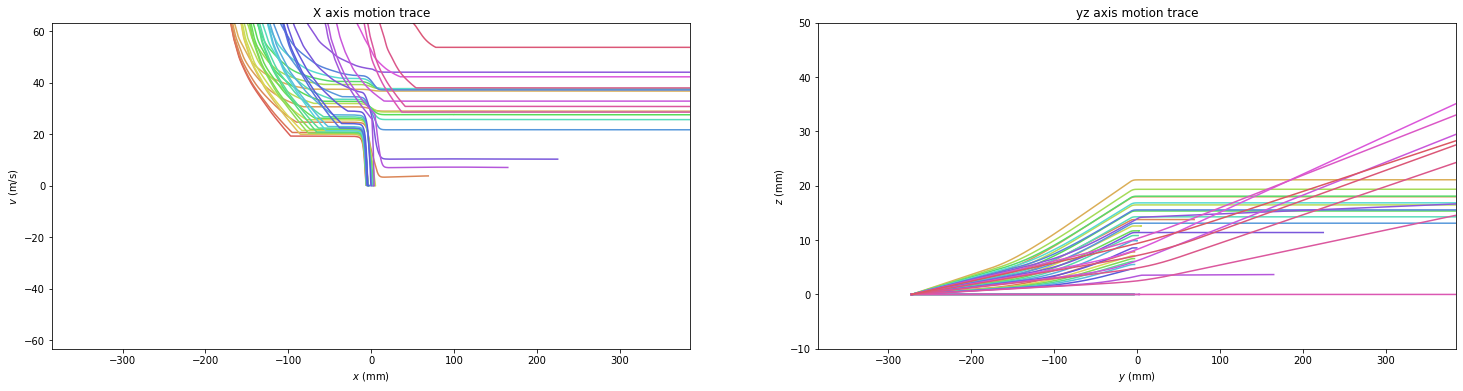

In [11]:
fig, ax = plt.subplots(1, 2,figsize=(25,6))
# plt.imshow(rateeq.profile['F'].F[0]/mass*1e-3*a0, origin='lower',
#            extent=(np.amin(zz*1000*x0), np.amax(zz*1000*x0),
#                    (np.amin(vv*v0)), (np.amax(vv*v0))),
#            aspect='auto',cmap='gray')
# cb1 = plt.colorbar()
# cb1.set_label('$a\ (\mathrm{km/s^2})$')
ax[0].set_xlabel('$x\ (\mathrm{mm})$')
ax[0].set_ylabel('$v\ (\mathrm{m/s})$')
ax[0].set_title('X axis motion trace')
ax[0].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
ax[0].set_ylim(-1*v_max*v0,v_max*v0)
ax[1].set_xlabel('$y\ (\mathrm{mm})$')
ax[1].set_ylabel('$z\ (\mathrm{mm})$')
ax[1].set_title('yz axis motion trace')
ax[1].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
ax[1].set_ylim(-10,0.05*1000)
fig.subplots_adjust(left=0.12,right=0.9)

colors = sns.color_palette('hls',len(sols_rate))

for sol,col in zip(sols_rate,colors):
    ax[0].plot(sol.r[0]*x0*1000,sol.v[0]*v0, color=col)
    ax[1].plot(sol.r[1]*x0*1000,sol.r[2]*x0*1000, color=col)
    
# fig.savefig('./Pictures/numerical_main_det=19.2.png')
# fig.savefig('./Pictures/Expected_main_det=19.8.png')

# fig.savefig("./Pictures/Cross_validation.png")
# fig.savefig("./Pictures/Fixed Bfield.png")

In [12]:
for sol in sols_rate:
    if len(sol.t_events[0])==1:
        print(sol.v[0][0]*np.sqrt(2), sol.v[2][0])